
Instituto Tecnológico de Estudios Superiores Monterrey
CAMPUS QUERÉTARO
Modelación de sistemas multiagentes con gráficas computacionales

Pedro Oscar Pérez Murueta
Alejandro Fernández
Denisse Lizbeth Maldonado Flores
Group 301

Actividad Medio Término
					
Hecho por:

Sebastian Armando Flores Lemus
A01709229



Date:
19/11/2023

Parte 1. Sistemas multiagentes

Descripción del problema
¡Felicidades! Eres el orgulloso propietario de 5 robots nuevos y un almacén lleno de cajas. El dueño
anterior del almacén lo dejó en completo desorden, por lo que depende de tus robots organizar las
cajas en algo parecido al orden y convertirlo en un negocio exitoso.
Cada robot está equipado con ruedas omnidireccionales y, por lo tanto, puede conducir en las
cuatro direcciones. Pueden recoger cajas en celdas de cuadrícula adyacentes con sus
manipuladores, luego llevarlas a otra ubicación e incluso construir pilas de hasta cinco cajas. Todos
los robots están equipados con la tecnología de sensores más nueva que les permite recibir datos
de sensores de las cuatro celdas adyacentes. Por tanto, es fácil distinguir si un campo está libre, es
una pared, contiene una pila de cajas (y cuantas cajas hay en la pila) o está ocupado por otro robot.
Los robots también tienen sensores de presión equipados que les indican si llevan una caja en ese
momento.

Lamentablemente, tu presupuesto resultó insuficiente para adquirir un software de gestión de
agentes múltiples de última generación. Pero eso no debería ser un gran problema ... ¿verdad? Tu
tarea es enseñar a sus robots cómo ordenar su almacén. La organización de los agentes depende de
ti, siempre que todas las cajas terminen en pilas ordenadas de cinco.
• Realiza la siguiente simulación:
o Inicializa las posiciones iniciales de las K cajas. Todas las cajas están a nivel de piso,
es decir, no hay pilas de cajas.
o Todos los agentes empiezan en posición aleatorias vacías.
o Se ejecuta el tiempo máximo establecido.
• Deberás recopilar la siguiente información durante la ejecución:
o Tiempo necesario hasta que todas las cajas están en pilas de máximo 5 cajas.
o Número de movimientos realizados por todos los robots.
o Analiza si existe una estrategia que podría disminuir el tiempo dedicado, así como
la cantidad de movimientos realizados. ¿Cómo sería? Descríbela.


In [400]:
from mesa import Agent, Model 
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import pandas as pd

import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['white', 'lightblue', 'blue', 'brown', 'navy', 'midnightblue', 'black'])

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [401]:
class BoxAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.is_in_stack = False

In [402]:
class RobotAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.carrying_box = False
        self.carried_box = None

    def manhattan_distance(self, pos1, pos2):
        x1, y1 = pos1
        x2, y2 = pos2
        return abs(x1 - x2) + abs(y1 - y2)

    def move_towards(self, target_position):
        x, y = self.pos
        tx, ty = target_position
        dx, dy = tx - x, ty - y
    
        if dx != 0:
            next_x = x + np.sign(dx)
            if self.can_move_to(next_x, y):
                self.model.grid.move_agent(self, (next_x, y))
                return
    
        if dy != 0:
            next_y = y + np.sign(dy)
            if self.can_move_to(x, next_y):
                self.model.grid.move_agent(self, (x, next_y))
                return

    def can_move_to(self, x, y):
        return self.model.grid.is_cell_empty((x, y)) or self.model.stacks.get((x, y), 0) < 5

    def find_nearest_box(self):
        nearest_box = None
        min_distance = float('inf')
        for agent in self.model.schedule.agents:
            if isinstance(agent, BoxAgent) and not agent.is_in_stack:
                distance = self.manhattan_distance(self.pos, agent.pos)
                if distance < min_distance:
                    nearest_box = agent.pos
                    min_distance = distance
        return nearest_box

    def find_nearest_stack_or_box_to_deposit(self):
        nearest_stack = None
        nearest_single_box = None
        min_stack_distance = float('inf')
        min_box_distance = float('inf')

        for stack_pos, stack_height in self.model.stacks.items():
            if stack_height < 5:
                distance = self.manhattan_distance(self.pos, stack_pos)
                if distance < min_stack_distance:
                    nearest_stack = stack_pos
                    min_stack_distance = distance

        if nearest_stack is None:
            for agent in self.model.schedule.agents:
                if isinstance(agent, BoxAgent) and not agent.is_in_stack and agent != self.carried_box:
                    distance = self.manhattan_distance(self.pos, agent.pos)
                    if distance < min_box_distance:
                        nearest_single_box = agent.pos
                        min_box_distance = distance

        return nearest_stack if nearest_stack is not None else nearest_single_box

    def pickup_box(self):
        if not self.carrying_box:
            contents = self.model.grid.get_cell_list_contents(self.pos)
            for content in contents:
                if isinstance(content, BoxAgent) and not content.is_in_stack:
                    self.carrying_box = True
                    self.carried_box = content
                    break

    def deposit_box(self, target):
        if self.carrying_box:
            self.model.grid.move_agent(self.carried_box, target)
            self.carried_box.is_in_stack = True
            self.carrying_box = False
            self.carried_box = None

    def perform_action(self):
        if self.carrying_box:
            target = self.find_nearest_stack_or_box_to_deposit()
            if target:
                if self.pos == target or target in self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False):
                    self.deposit_box(target)
                else:
                    self.move_towards(target)
        else:
            target = self.find_nearest_box()
            if target:
                self.move_towards(target)
                if self.pos == target:
                    self.pickup_box()

    def step(self):
        self.perform_action()


In [403]:
def get_grid(model):
    grid_state = np.zeros((model.grid.width, model.grid.height), dtype=int)

    for cell_contents, (x, y) in model.grid.coord_iter():
        if not isinstance(cell_contents, list):
            cell_contents = [cell_contents]

        for content in cell_contents:
            if isinstance(content, RobotAgent):
                grid_state[x][y] = 1
            elif isinstance(content, BoxAgent):
                grid_state[x][y] = 2

    return grid_state

In [404]:
class WarehouseModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        self.stacks = {}  
        self.num_agents = num_agents
        self.num_boxes = num_boxes
        self.steps = 0

        self.create_agents()

    def create_agents(self):
        agent_id = 0

        for _ in range(self.num_agents):
            robot = RobotAgent(agent_id, self)
            self.schedule.add(robot)
            self.grid.place_agent(robot, self.random_position_not_occupied())
            agent_id += 1

        for _ in range(self.num_boxes):
            box = BoxAgent(agent_id, self)
            self.schedule.add(box)
            self.grid.place_agent(box, self.random_position_not_occupied())
            agent_id += 1

    def random_position_not_occupied(self):
        while True:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            if self.grid.is_cell_empty((x, y)):
                return (x, y)

    def update_stacks(self):
        self.stacks = {}
        for contents in self.grid.coord_iter():
            stack_pos = contents[1]
            stack_count = sum(1 for agent in contents[0] if isinstance(agent, BoxAgent))
            if stack_count > 1:  # Considerar como stack si hay más de una caja
                self.stacks[stack_pos] = stack_count

    def all_boxes_stacked(self):
        for agent in self.schedule.agents:
            if isinstance(agent, BoxAgent) and not agent.is_in_stack:
                return False 
        return

    def step(self):
        self.update_stacks()
        self.schedule.step()
        self.datacollector.collect(self)
        self.steps += 1
        if self.all_boxes_stacked():
            self.running = False 


In [405]:
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
NUM_BOXES = 25
MAX_STEPS = 4000

model = WarehouseModel(WIDTH, HEIGHT, NUM_AGENTS, NUM_BOXES)
model.running = True

for i in range(MAX_STEPS):
    if not model.running:
        break
    model.step()

data = model.datacollector.get_model_vars_dataframe()

print(f'Pasos totales para organizar todas las cajas: {model.schedule.steps}')


Pasos totales para organizar todas las cajas: 4000


In [406]:
all_grid = model.datacollector.get_model_vars_dataframe()

5


/var/folders/f0/_1kmynrd62zdz552kgfzq_9w0000gn/T/ipykernel_61170/270161552.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


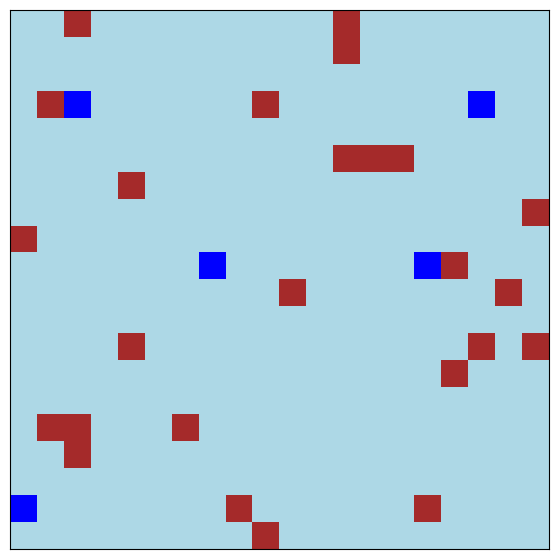

In [407]:
# Create the initial plot
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
initial_grid = get_grid(model)  # Get the initial state of the grid
patch = plt.imshow(initial_grid, cmap=cmap, vmin=-1, vmax=5)

# Create the animation
def animate(frame):
    patch.set_data(data.iloc[frame][0])
steps = model.steps
print(len(model.stacks))

# anim = animation.FuncAnimation(fig, animate, frames=range(model.schedule.steps), interval=100)
anim = animation.FuncAnimation(fig , animate, frames=350, interval=100)

In [408]:
anim

/var/folders/f0/_1kmynrd62zdz552kgfzq_9w0000gn/T/ipykernel_61170/270161552.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


Reflexión:

La actividad de medio término fue mucho más desafiante que actividades previas, ya que teníamos que incluir muchas más variables y casos especiales para que la simulación funcionara como se pidió. Las actividades anteriores, en especial la de limpiar las celdas, fueron de mucho valor, ya que nos permitieron aprender cómo funcionan los métodos más esenciales y cómo realizar las técnicas críticas para la actividad, aunque esta actividad sí era notoriamente más compleja que las anteriores.

Para la solución, se crearon 3 modelos: un modelo para la caja que simplemente tiene una bandera para saber si la caja se encuentra en una torre y así no pueda ser recogida por otros agentes. El crear un modelo también nos facilita crear las cajas en el grid. El segundo modelo es el robot encargado de crear las pilas y de organizar el almacén. Este robot cuenta con más propiedades y más métodos, ya que es el agente principal de la simulación. Cuenta únicamente con una variable para saber si está transportando una caja en un cierto momento y nos ayuda para la lógica, ya que solo puede cargar una caja a la vez. La segunda variable nos ayuda a llevar control de la caja que se está moviendo. Cuenta con múltiples métodos para poder hacer el movimiento deseado, para levantar una caja, para hacer el "stack" sobre otra caja y para saber qué dirección debe seguir para realizar la acción de stack.

El último modelo es para crear el modelo del almacén, donde creamos los agentes y llevamos el progreso de los stacks que tenemos presentes. A pesar de que se cumplió con éxito la simulación, hay ciertas áreas de oportunidad que se pueden implementar para optimizarla. Sin duda, lo más importante sería optimizar el movimiento de los agentes, ya que se desperdicia una enorme cantidad de pasos debido a que el movimiento es aleatorio. Muchas veces un agente repite su ruta; sin duda, se puede tener una lógica más eficiente para que los agentes recuerden o puedan avisarle a otros dónde se encuentran las cajas. Si un agente lleva consigo una caja pero en su ruta encuentra múltiples cajas en celdas vecinas, puede avisarle a los otros agentes y eventualmente pueden conocer la posición de las cajas teniendo una ruta más eficiente.

Durante la simulación, me di cuenta de que se llega a un cierto punto donde los agentes se amontonan y hacen la misma ruta para ir por las mismas cajas. Hay diferentes formas en que se puede optimizar esto; podemos dividir el grid por cuadrantes o secciones para que haya un agente encargado en cada sesión y así nunca se amontonen. Otra solución puede ser "marcar" una caja aunque el agente no la esté cargando; esto evita que más de un agente vaya a recoger la misma caja y así sigan la misma ruta.